In [1]:
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import optuna
import statistics
import re
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, TargetEncoder
import category_encoders as ce
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from functools import partial
import warnings

warnings.filterwarnings('ignore')


In [2]:
sys.path.append(os.path.abspath("/home/bk_anupam/code/ML/ML_UTILS/"))

In [3]:
import train_tabular_utils as tt
import cv_split_utils
import enums
import data_utils

In [26]:
class Config:
    RUN_MODE = "LOCAL"
    RANDOM_SEED = 42
    NUM_FOLDS = 5
    TARGET_COL_NAME = "price"        
    SCALER = enums.Scaler.StandardScaler
    METRIC = enums.Metrics.RMSE
    # These values are more dynamic   
    MODEL_TYPE = enums.ModelName.CatBoost
    NUM_TUNING_TRIALS = 25
    TUNE_ON_SINGLE_FOLD = True
    TRAIN_SINGLE_FOLD = True    
    PERSIST_MODEL = False    
    USE_MANUAL_FEATURES = False
    USE_ORIGINAL_DATA = False    
    FEATURE_SELECTION_METHOD = None
    NUM_CLASSES = None

COLS_TO_LEAVE = ["id", "price", "kfold", "target_grp"]
CPU_COUNT = os.cpu_count()

DATA_READPATH = "./data/"
DATA_WRITEPATH = "./output/"
SUBMISSION_FILEPATH = DATA_READPATH
if Config.RUN_MODE == "KAGGLE":    
    DATA_READPATH = "/kaggle/input/playground-series-s4e6/"
    if Config.USE_OPENFE_FEATURES:
        DATA_READPATH = "/kaggle/input/ps4e6-openfe/"
    SUBMISSION_FILEPATH = "/kaggle/input/playground-series-s4e6/"
    DATA_WRITEPATH = "/kaggle/working/"

In [27]:
model_static_params = {
    enums.ModelName.XGBoost: {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        "seed": Config.RANDOM_SEED,
        "verbosity": 0,
    },
    enums.ModelName.LGBM: {
        "objective": "root_mean_squared_error",
        "metric": 'rmse',
        "verbosity": -1,    # <0: fatal, =0: error (warn), =1: info, >1: debug
        "boosting_type": "gbdt"
    },
    enums.ModelName.CatBoost: {
        "objective": "RMSE",
        "verbose": 0,
        "random_seed": Config.RANDOM_SEED,
        "eval_metric": "RMSE",
        'grow_policy':  'Lossguide',
        #'bootstrap_type': 'Poisson',
        'task_type': 'CPU'
    },
    enums.ModelName.RandomForest: {
        "random_state": Config.RANDOM_SEED,
        "n_jobs": -1
    }
}

In [28]:
# For RandomForest
# tuned_model_params = {'n_estimators': 1300, 'max_depth': 17, 'min_samples_leaf': 3, 'min_samples_split': 3, 'max_features': 'sqrt'}
# For CatBoost
# tuned_model_params = {
#     'iterations': 1500,
#     'depth': 5,
#     'learning_rate': 0.05602656173812734,
#     'l2_leaf_reg': 3.96021970280269,
#     'bagging_temperature': 8.793196499678535,
#     'border_count': 185,
#     'loss_function': 'RMSE',
#     'eval_metric': 'RMSE',
# }
# For XGBoost
# tuned_model_params = {'n_estimators': 1400, 'learning_rate': 0.10270166896064774, 'max_depth': 30, 'min_child_weight': 7, 'gamma': 4.123490349502186, 'subsample': 0.5067185283456936, 'colsample_bytree': 0.7289930512882908, 'reg_alpha': 0.5971832077526927, 'reg_lambda': 9.433125479981229, 'early_stopping_rounds': 260}
# For LGBM
# tuned_model_params = {'learning_rate': 0.050431114227825063, 'n_estimators': 1500, 'max_depth': 6, 'min_data_in_leaf': 92, 'min_child_weight': 6, 'num_leaves': 428, 'reg_lambda': 130.60718838770154, 'early_stopping_rounds': 365, 'subsample': 0.8586720764925466, 'colsample_bytree': 0.5962542688745494, 'reg_alpha': 0.5737569015209647}

tuned_model_params = None

In [29]:
if Config.USE_MANUAL_FEATURES:
    df_train = pd.read_csv(DATA_READPATH + "train_preprocessed.csv")
    df_test = pd.read_csv(DATA_READPATH + "test_preprocessed.csv")
else:
    df_train = pd.read_csv(DATA_READPATH + "train.csv")
    df_test = pd.read_csv(DATA_READPATH + "test.csv")
# keep a copy of original train and test data for later use
df_train_orig = df_train.copy()
df_test_orig = df_test.copy()

In [31]:
df_train = cv_split_utils.strat_kfold_dataframe(df_train, 
                                                random_state=Config.RANDOM_SEED, 
                                                num_folds=Config.NUM_FOLDS,
                                                target_col_name=Config.TARGET_COL_NAME, 
                                                n_bins=25)

In [32]:
imputation_config = None
if Config.USE_MANUAL_FEATURES:
    # Define imputation configuration
    imputation_config = {
        'horsepower': KNNImputer(),
        'capacity': KNNImputer(),
        'cylinders': KNNImputer()
    }

In [33]:
df_train.fillna({"clean_title": "Unknown", "accident": "Unknown", "fuel_type": "Unknown"}, inplace=True)
if Config.USE_MANUAL_FEATURES:
    df_train.fillna({"fuel": "Unknown"})

In [34]:
# do not include 'id' column in the list of int columns
int_cols = [col for col in df_train.columns if df_train[col].dtypes == 'int64' and col not in COLS_TO_LEAVE]
float_cols = [col for col in df_train.columns if df_train[col].dtypes == 'float64']
bool_cols = [col for col in df_train.columns if df_train[col].dtypes == 'bool']
cat_cols = [col for col in df_train.columns if df_train[col].dtypes == 'object' and col not in COLS_TO_LEAVE]
feature_cols = [x for x in df_train.columns if x not in COLS_TO_LEAVE]

In [35]:
print(feature_cols)
print(cat_cols)

['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']


In [36]:
# Convert all categorical columns to string type
df_train[cat_cols] = df_train[cat_cols].astype(str)
cat_encoders = {col: [
                       OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1),
                       TargetEncoder(target_type="continuous")  
                     ]
                    for col in cat_cols
                }

In [37]:
# preprocessing
preprocessor = None
scaler = StandardScaler()
# onehot_encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore", categories=int_feature_categories)
preprocessor = ColumnTransformer(
    transformers=[                
        ("scaler", scaler, int_cols+float_cols),
        #("onehot", onehot_encoder, int_features),                
    ], remainder="passthrough"
)

In [38]:
def get_model_tuning_params(trial, model_name):
    if model_name == enums.ModelName.LogisticRegression:
        penalty = ['l1', 'l2']
        return {        
            "C": trial.suggest_loguniform("C", 1e-3, 100),
            "penalty": trial.suggest_categorical("penalty", penalty)
        }    
    if model_name == enums.ModelName.RandomForest:
        return {        
            "n_estimators": trial.suggest_int("n_estimators", 200, 3000, step=100),
            "max_depth": trial.suggest_int("max_depth", 10, 30),
            "min_samples_leaf": trial.suggest_int("min_samples_leaf", 2, 16),
            "min_samples_split": trial.suggest_int("min_samples_split", 2, 16),
            "max_features": trial.suggest_categorical("max_features", ["log2", "sqrt", None])
        }
    if model_name == enums.ModelName.CatBoost:
        return get_catboost_tuning_params(trial)
    if model_name == enums.ModelName.XGBoost:
        return get_xgb_tuning_params_level2(trial) 
    if model_name == enums.ModelName.LGBM:
        return get_lgbm_tuning_params(trial)   

In [39]:
def hyperparams_tuning_objective(trial, model_name, preprocessor, df,  
                                 feature_cols, metric, target_col_name, single_fold=False, num_folds=5,
                                 imputation_config=None):               
    model_params = get_model_tuning_params(trial, model_name)    
    fold_metrics_model, _, _ = tt.train_and_validate(
                                        model_name=model_name,
                                        model_params=model_params,
                                        preprocessor=preprocessor,
                                        df=df,
                                        feature_cols=feature_cols,
                                        target_col_name=target_col_name,
                                        metric=metric,
                                        single_fold=single_fold,
                                        num_folds=num_folds,
                                        suppress_print=True,
                                        imputation_config=imputation_config
                                    )
    fold_metrics = [x[0] for x in fold_metrics_model]
    mean_metric = statistics.mean(fold_metrics)                
    return mean_metric

In [40]:
def tune_model_params(study_name, study_direction, num_trials, model_name, 
                      preprocessor, df,  feature_cols, metric, target_col_name, 
                      single_fold=False, num_folds=5, imputation_config=None):
    model_params_tuning_obj_partial = partial(
        hyperparams_tuning_objective,
        model_name=model_name,        
        preprocessor=preprocessor,        
        df=df,
        feature_cols=feature_cols,
        metric=metric,
        target_col_name=target_col_name,
        single_fold=single_fold,
        num_folds=num_folds,
        imputation_config=imputation_config
    )
    study = optuna.create_study(direction=study_direction, study_name=study_name)
    study.optimize(model_params_tuning_obj_partial, n_trials=num_trials)
    best_trial = study.best_trial
    print(f"Best trial: number = {best_trial.number}, value = {best_trial.value}, params = {best_trial.params}")
    return best_trial.params

In [41]:
# if tuned_model_params is None:
#     #df = df_train.sample(frac=0.1, random_state=Config.RANDOM_SEED)
#     tuned_model_params = tune_model_params(
#                             study_name=Config.MODEL_TYPE + "_ModelTuning", 
#                             study_direction="maximize",
#                             num_trials=Config.NUM_TUNING_TRIALS,
#                             model_name=Config.MODEL_TYPE,
#                             preprocessor=preprocessor,
#                             df=df_train,
#                             feature_cols=feature_cols,
#                             metric=Config.METRIC,
#                             target_col_name=Config.TARGET_COL_NAME,
#                             single_fold=Config.TUNE_ON_SINGLE_FOLD,
#                             num_folds=Config.NUM_FOLDS,
#                             imputation_config=imputation_config
#                     )

In [42]:
model_params = None
params_static = model_static_params.get(Config.MODEL_TYPE)
if tuned_model_params is not None:
    model_params = {**params_static, **tuned_model_params}
else:
    model_params = params_static

print(model_params)    

{'objective': 'RMSE', 'verbose': 0, 'random_seed': 42, 'eval_metric': 'RMSE', 'grow_policy': 'Lossguide', 'task_type': 'CPU'}


In [45]:
%%time
fold_metrics_model, df_oof_preds, preprocessor = tt.train_and_validate(
        model_name=Config.MODEL_TYPE,
        model_params=model_params,
        preprocessor=None,
        df=df_train,
        feature_cols=feature_cols,
        target_col_name=Config.TARGET_COL_NAME,
        metric=Config.METRIC,
        single_fold=Config.TRAIN_SINGLE_FOLD,
        num_folds=Config.NUM_FOLDS,
        suppress_print=False,
        imputation_config=imputation_config,
        cat_features=None,
        cat_encoders=cat_encoders
)

Fold 0 - CatBoost - RMSE : 72581.10861457513
CatBoost metric=RMSE CV score = 72581.10861457513
CatBoost Mean RMSE = 72581.10861457513, std = 0.0
CPU times: user 2min 11s, sys: 25.6 s, total: 2min 36s
Wall time: 28.7 s


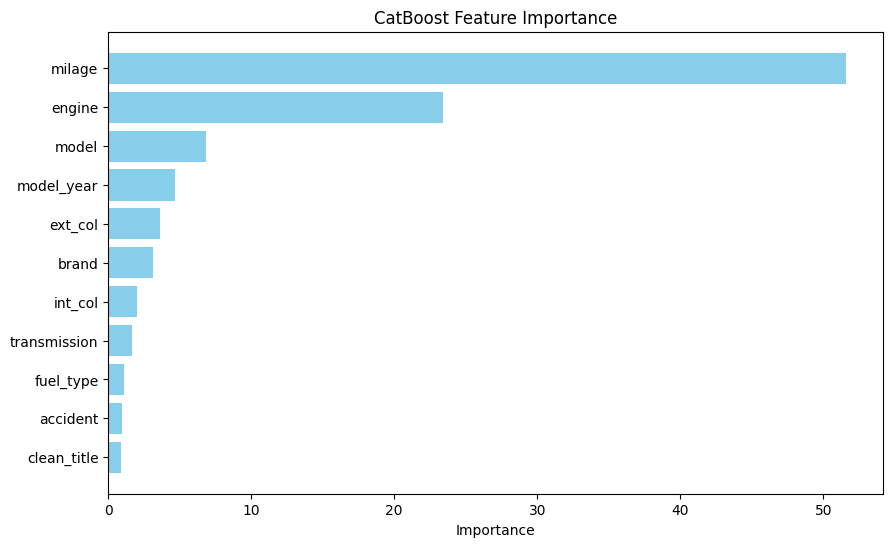

In [46]:
# Get feature importance
model = fold_metrics_model[0][1]
# Create a DataFrame for visualization
df_feature_imp = pd.DataFrame({
    'f_name': feature_cols,
    'f_imp': model.get_feature_importance()
})
# Sort the DataFrame by importance
df_feature_imp = df_feature_imp.sort_values(by='f_imp', ascending=False)
#data_utils.plot_feature_importance(df_feature_imp)
# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(df_feature_imp['f_name'], df_feature_imp['f_imp'], color='skyblue')
plt.xlabel('Importance')
plt.title('CatBoost Feature Importance')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()
